In [1]:
%load_ext autoreload

%autoreload 2

In [65]:
import sys
sys.path.append('../')

from ase.db import connect
import pyro
from src.models.bnn import BNN, NN
from src.models.nets.network import NetAtom
import torch
import pytorch_lightning as L
import torch.utils.data as data
import numpy as np
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from optuna import Study
import optuna
from optuna.trial import Trial

from src.datamodule.aenet_datamodule import AenetDataModule

In [66]:
datamodele = AenetDataModule(
    data_dir='../data/IrO/train.in',
    batch_size=200,
    test_split=0.1,
    valid_split=0.1
    )

In [67]:
net = NetAtom(
    datamodele.input_size, 
    datamodele.hidden_size, 
    datamodele.species, 
    datamodele.active_names, 
    datamodele.alpha,
    'cpu'
)

In [68]:
model_kwargs = {'net': net,
        'lr': 0.00025616626859234823,
        'pretrain_epochs': 5,
        'mc_samples_train': 1,
        'mc_samples_eval': 20, 
        'dataset_size': datamodele.train_size, 
        'fit_context': 'lrt', 
        'prior_loc': 0, 
        'prior_scale': 0.3726682199695302, 
        'guide': 'normal', 
        'q_scale': 0.00127000766093029489207278289472795143,
        'obs_scale' :  0.8115512648735741}

In [69]:
Params = {'lr': 0.0008125578881617974, 
          'mc_samples_train': 2, 
          'obs_scale': 0.9917358818102286, 
          'pretrain_epochs': 0, 
          'prior_scale': 0.21958647597273184, 
          'q_scale': 0.00033014029845893105}

model_kwargs.update(Params)

In [70]:
early_stopping = EarlyStopping(monitor='elbo/val', min_delta = 0., # minimum change in the monitored quantity to qualify as an improvement
  patience= 3, # number of checks with no improvement after which training will be stopped
  verbose= False, # verbosity mode
  mode= "min", # "max" means higher metric value is better, can be also "min"
  strict= True, # whether to crash the training if monitor is not found in the validation metrics
  check_finite= True,) # when set True, stops training when the monitor becomes NaN or infinite
#   'stopping_threshold'= null, # stop training immediately once the monitored quantity reaches this threshold
#   'divergence_threshold'= null, # stop training as soon as the monitored quantity becomes worse than this threshold
#   'check_on_train_epoch_end'= null,)

early_stopping = EarlyStopping(
    monitor='elbo/val',
    patience=100,
    mode='min' )

In [75]:
model = BNN(**model_kwargs)
trainer = L.Trainer(max_epochs = 2000)
trainer.fit(model=model, datamodule=datamodele, ckpt_path='/home/riccardo/bin/repos/aenet-bnn/src/logs/train_lrt/runs/2024-04-18_16-48-06/checkpoints/epoch_1817-step_7272.ckpt')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/riccardo/anaconda3/envs/bayesian/lib/python3.12/site-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 0 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/home/riccardo/anaconda3/envs/bayesian/lib/python3.12/site-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/home/riccardo/anaconda3/envs/bayesian/lib/python3.12/site-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
Restoring states from the checkpoint path at /home/riccardo/bin/repos/aenet-bnn/src/logs/train_lrt/runs/2024-04-18_16-48-06/checkp

/home/riccardo/anaconda3/envs/bayesian/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1825:  67%|██████▋   | 2/3 [00:00<00:00, 16.86it/s, v_num=31]

/home/riccardo/anaconda3/envs/bayesian/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [78]:
trainer.logged_metrics

{'elbo/val': tensor(526.5217),
 'mse/val': tensor(11.4140, dtype=torch.float64),
 'kl/val': tensor(6695.9517),
 'likelihood/val': tensor(-6169.4302),
 'mse/train': tensor(14.6017),
 'elbo/train': tensor(1604.4745),
 'kl/train': tensor(6696.4517),
 'likelihood/train': tensor(-5091.9771)}

In [61]:
valid = datamodele.grouped_valid_data
x = valid[0][10], valid[0][12]
y_true = valid[0][11]
y_pred, y_std = model.bnn.predict(x[0], x[1], num_predictions=20)

y_pred = y_pred.numpy()
y_std = y_std.numpy() #- model_kwargs['obs_scale']
y_true = y_true.numpy()

R2 score: 0.024


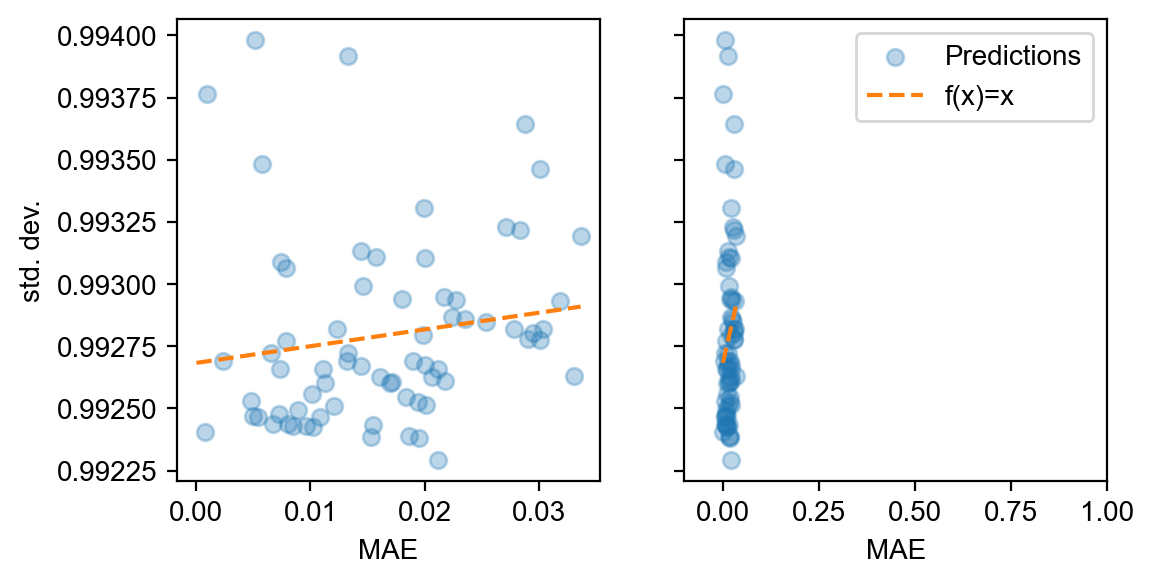

In [62]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams.update({
    "figure.dpi" : 200,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "font.size" : 10,
    'mathtext.default': 'regular'
})

regr = LinearRegression()

x_model = abs(y_pred-y_true).reshape(-1,1)
y_model = y_std.reshape(-1,1)

regr.fit(x_model, y_model)
y_model_pred = regr.predict(x_model)
x_modelito = np.linspace(0, max(x_model), 100).reshape(-1,1)


fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=True)

ax[0].scatter(x_model, y_model, alpha=0.3)
ax[0].plot(x_modelito, regr.predict(x_modelito), '--', color='tab:orange', label='f(x)=x')


print('R2 score: {:.3f}'.format(r2_score(y_model, y_model_pred)))
ax[1].scatter(x_model, y_model, alpha=0.3, label='Predictions')

ax[1].plot(x_modelito, regr.predict(x_modelito), '--', color='tab:orange', label='f(x)=x')

ax[1].set_xlim(-0.1,1)
#ax[0].text(0.1,1.7, 'R2 score: {:.3f}'.format(r2_score(y_model, y_model_pred)))
ax[1].set_xlabel('MAE')
ax[0].set_xlabel('MAE')
ax[0].set_ylabel('std. dev.')
ax[1].legend()
#plt.xlim(0,0.5)

<Axes: title={'center': 'Residuals vs. Predictive Standard Deviations'}, xlabel='Standard Deviations (Scaled)', ylabel='Residuals (Absolute Value)'>

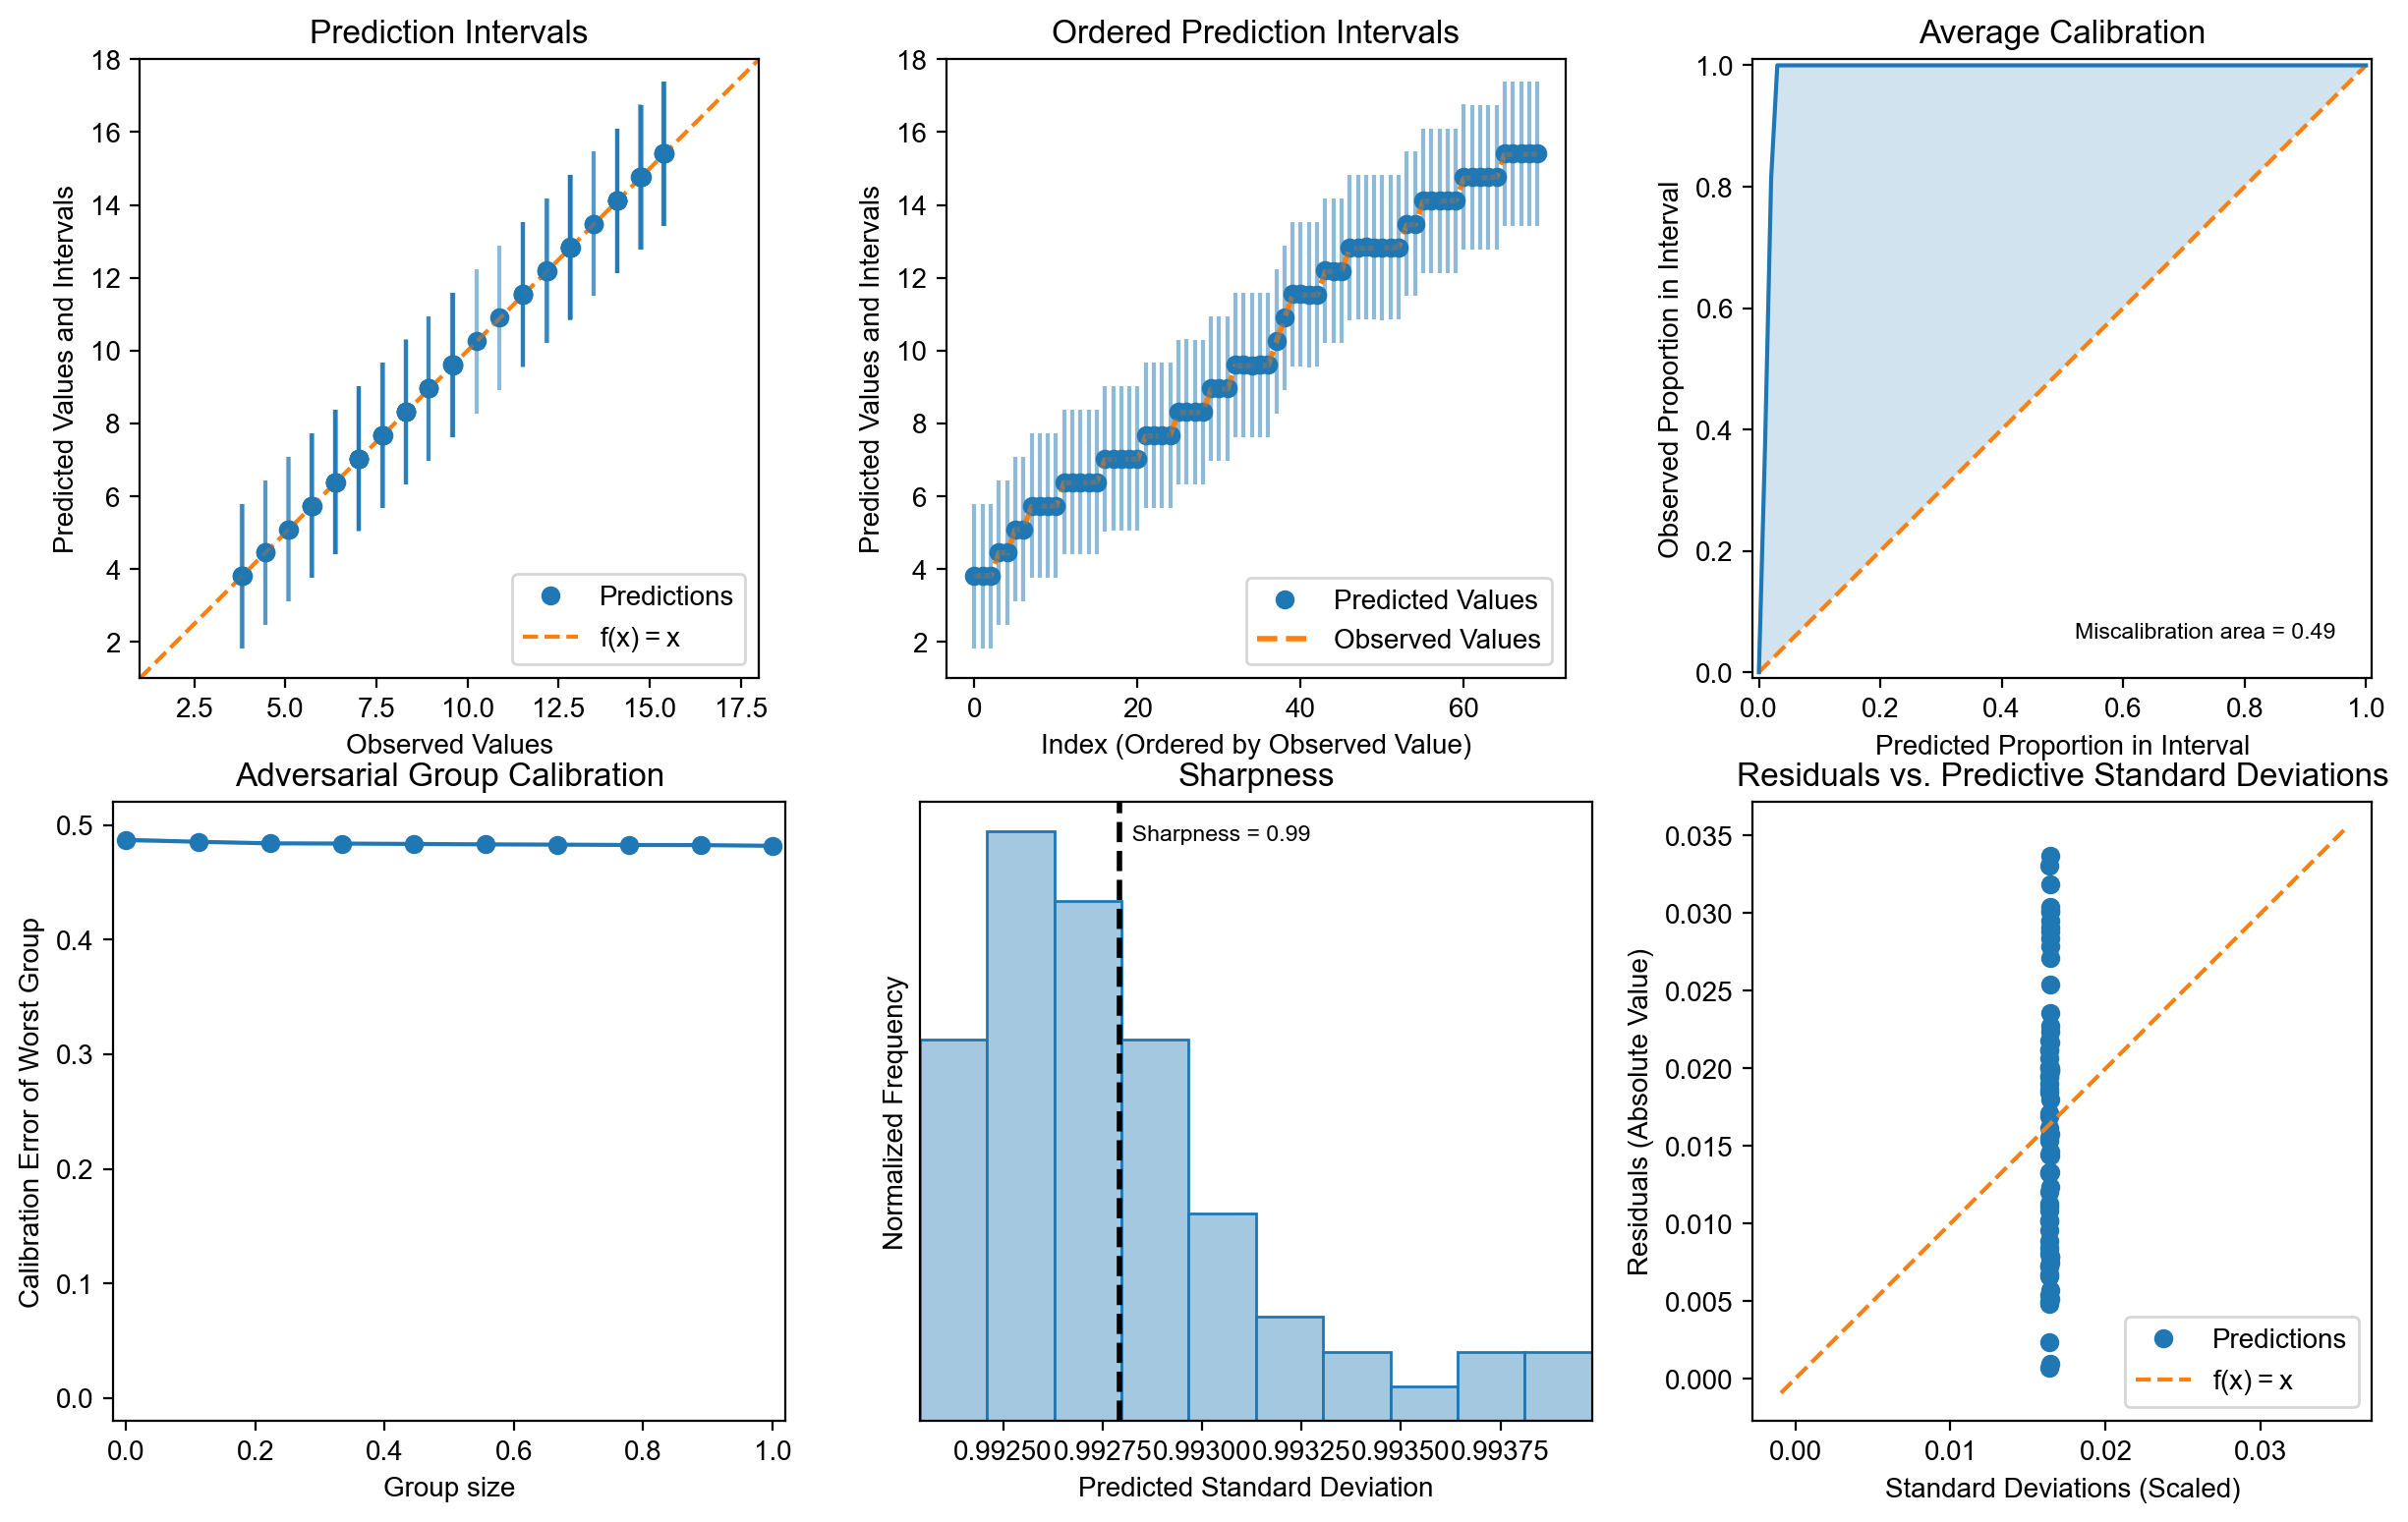

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct

plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(2, 3, figsize=(15, 9))
ax = ax.flat
uct.plot_intervals(y_pred, y_std, y_true, ax=ax[0])
uct.plot_intervals_ordered(y_pred, y_std, y_true, ax=ax[1])
uct.plot_calibration(y_pred, y_std, y_true, ax=ax[2])
uct.plot_adversarial_group_calibration(y_pred, y_std, y_true, ax=ax[3])
uct.plot_sharpness(y_std, ax=ax[4])
uct.plot_residuals_vs_stds(y_pred, y_std, y_true, ax=ax[5])

In [56]:
model_kwargs['obs_scale']

0.9917358818102286